In [167]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
import seaborn as sb
from scipy.stats import kurtosis, skew, spearmanr
from scipy.linalg import norm, lstsq
from scipy.stats import pearsonr

In [175]:
#Author: Fabian Pedregosa-Izquierdo, f@bianp.net
#Testing: Valentina Borghesani, valentinaborghesani@gmail.com

def partial_corr(C):
#    Returns the sample linear partial correlation coefficients between pairs of variables in C, controlling 
#    for the remaining variables in C.

#    Parameters
#    C : array-like, shape (n, p)
#        Array with the different variables. Each column of C is taken as a variable
#    Returns
#    P : array-like, shape (p, p)
#        P[i, j] contains the partial correlation of C[:, i] and C[:, j] controlling
#        for the remaining variables in C.

    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = lstsq(C[:, idx], C[:, j])[0]
            beta_j = lstsq(C[:, idx], C[:, i])[0]
            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] - C[:, idx].dot(beta_j)
            corr = pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
    return P_corr

/tmp/ipykernel_41617/844739284.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});
/tmp/ipykernel_41617/844739284.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});
/tmp/ipykernel_41617/844739284.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});
/tmp/ipykernel_41617/844739284.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get

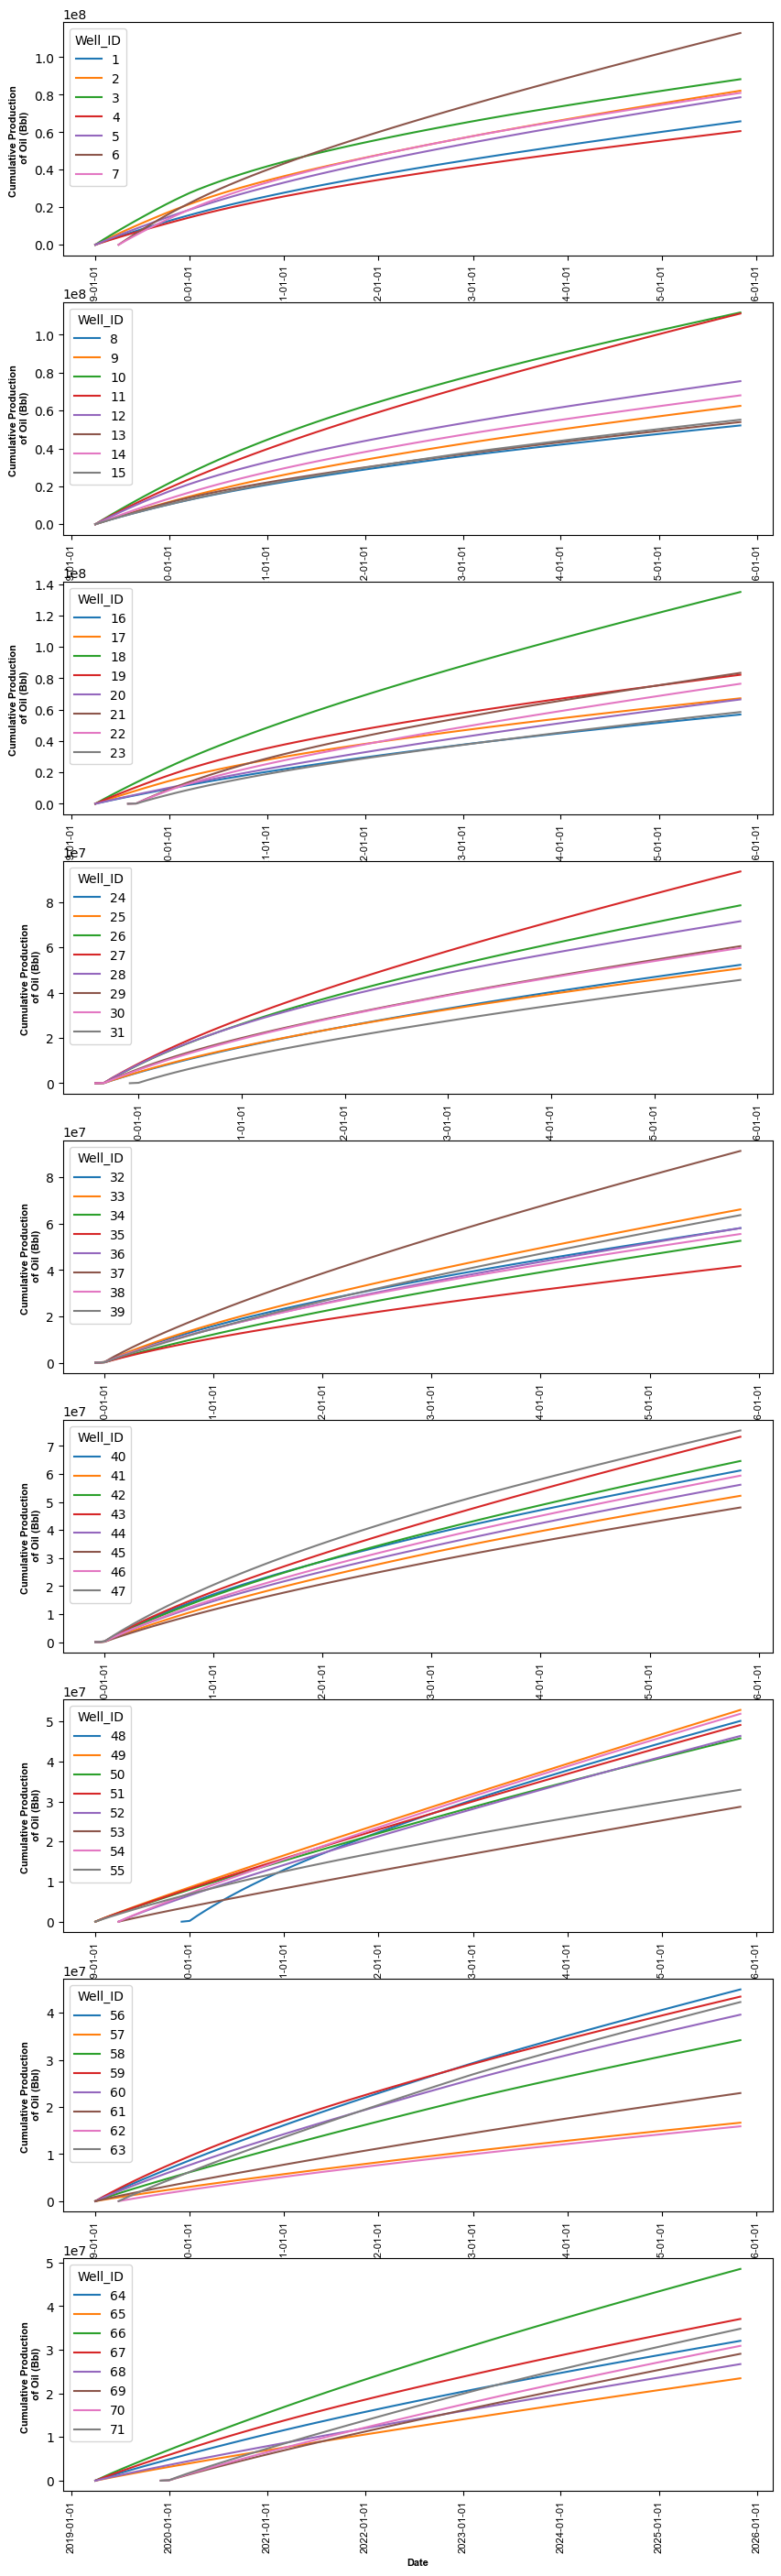

In [137]:


df = pd.read_csv( "production.csv",parse_dates=["Date"] )
fig,ax = plt.subplots( 9,1,figsize=(10,35) )




for i in range(9):
    wellidx     = i*8
    colors = [color_map[w] for w in df[(df["Well_ID"]>=wellidx) & (df["Well_ID"]<=wellidx+8)]["Well_ID"]]
    sb.lineplot( data=df[(df["Well_ID"]>=wellidx) & (df["Well_ID"]<=wellidx+7)], x="Date",
                 y="Cumulative Oil Production, BBL",
                 hue="Well_ID",palette="tab10",ax=ax[i] )
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax[i].set_ylabel( "Cumulative Production \n of Oil (Bbl)",fontdict={"family":"Arial","size":8,"weight":"bold"} )
    ax[i].set_xlabel( "Date",fontdict={"family":"Arial","size":8,"weight":"bold"} )
    ax[i].set_xticklabels(ax[i].get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});

In [39]:
np.unique( df["Well_ID"] )

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71])

/tmp/ipykernel_41617/2628011662.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});


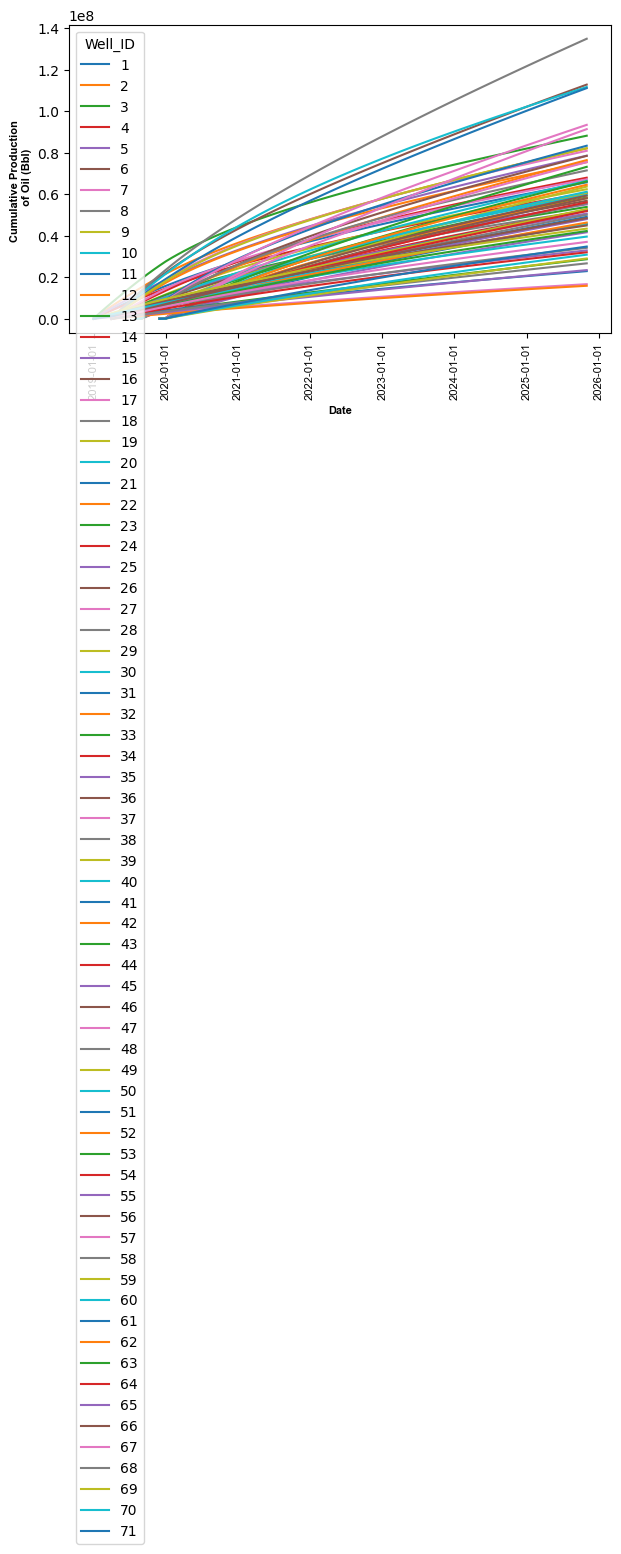

In [46]:
fig,ax = plt.subplots( figsize=(7,4 ) )
sb.lineplot( data=df, x="Date",
                 y="Cumulative Oil Production, BBL",
                 hue="Well_ID",palette="tab10",ax=ax )
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel( "Cumulative Production \n of Oil (Bbl)",fontdict={"family":"Arial","size":8,"weight":"bold"} )
ax.set_xlabel( "Date",fontdict={"family":"Arial","size":8,"weight":"bold"} )
ax.set_xticklabels(ax.get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});

In [170]:
dflogs = pd.read_csv( "logs.csv" )
 
df["gamma_var"] = 0
df["gamma_skew"] = 0
df["months"] = 0
df["mean_por"] = 0
df["mean_perm"] = 0
df["kurt_perm"] = 0
df["neighbor_density_25"] = 0
df["neighbor_density_70"] = 0
df["X"] = 0
df["Y"] = 0
df["cumulative_3y"] = 0

def calculate_well_density( xvals,yvals,allx,ally,allIDs,quantile ):
    x   = xvals[0]
    y   = yvals[0]
    ids = np.unique( allIDs )
    dists = [  ]
    for id in ids:
        idxs=np.argwhere( allIDs==id )
        xs  = allx[idxs][0]
        ys  = ally[idxs][0]
        dists.append( norm( np.array([x-xs,y-ys]) ) )
    return np.quantile( dists,quantile )

for id in np.unique(dflogs["Well_ID"]):
    df.loc[df["Well_ID"]==id,"X"] = np.unique( dflogs[dflogs["Well_ID"]==id]["X"] )[0]
    df.loc[df["Well_ID"]==id,"Y"] = np.unique( dflogs[dflogs["Well_ID"]==id]["Y"] )[0]
    df.loc[df["Well_ID"]==id,"gamma_var"] = np.std( dflogs[dflogs["Well_ID"]==id]["GR"] )
    df.loc[df["Well_ID"]==id,"gamma_skew"] = skew( dflogs[dflogs["Well_ID"]==id]["GR"].values )
    df.loc[df["Well_ID"]==id,"mean_por"] = np.mean( dflogs[dflogs["Well_ID"]==id]["phi"] )
    df.loc[df["Well_ID"]==id,"mean_perm"] = np.mean( dflogs[dflogs["Well_ID"]==id]["perm"] )
    df.loc[df["Well_ID"]==id,"kurt_perm"] = kurtosis( dflogs[dflogs["Well_ID"]==id]["perm"].values )
    df.loc[df["Well_ID"]==id,"neighbor_density_25"] = calculate_well_density( dflogs[dflogs["Well_ID"]==id]["X"].values,dflogs[dflogs["Well_ID"]==id]["Y"].values,
                                                                           dflogs["X"].values,dflogs["Y"].values,dflogs["Well_ID"],0.25 )
    df.loc[df["Well_ID"]==id,"neighbor_density_70"] = calculate_well_density( dflogs[dflogs["Well_ID"]==id]["X"].values,dflogs[dflogs["Well_ID"]==id]["Y"].values,
                                                                           dflogs["X"].values,dflogs["Y"].values,dflogs["Well_ID"],0.7 )
    df.loc[df["Well_ID"] == id, "months"] = (
        df.loc[df["Well_ID"] == id, "Date"]
        - df.loc[df["Well_ID"] == id, "Date"].min(  )
    ).dt.days
    monthsWell          = df[df["Well_ID"]==id]["months"] - 36
    prodWell          = df[df["Well_ID"]==id]["Cumulative Oil Production, BBL"]
    df.loc[df["Well_ID"]==id,"cumulative_3y"] = np.min( prodWell[monthsWell>0] )
    
df["months"]=df["months"]/30

/tmp/ipykernel_41617/4061625225.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '12.616559342992652' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df["Well_ID"]==id,"gamma_var"] = np.std( dflogs[dflogs["Well_ID"]==id]["GR"] )
/tmp/ipykernel_41617/4061625225.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.22543444778947366' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df["Well_ID"]==id,"mean_por"] = np.mean( dflogs[dflogs["Well_ID"]==id]["phi"] )
/tmp/ipykernel_41617/4061625225.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '884.3293154277777' has dtype incompatible with int64, please explicitly cast to a compatible dtype first

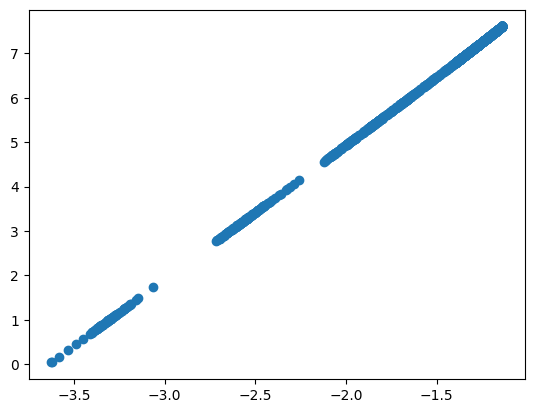

In [184]:
plt.scatter( np.log( dflogs["phi"] ),np.log(dflogs["perm"]) )

In [95]:
dflogs

,Well_ID,X,Y,Z,AI,SI,Vp,Vs,rho_b,rho_f,...,Kdry,Kf,Ksat,G0,Gdry,Gsat,facies,phi,perm,GR
0,1,33,127,19,5943276.00,NaN,2509.036133,1090.884644,2.368749,1.031188,...,3.545598,2.053309,11.153387,22.357136,2.818880,2.818880,4.0,0.168519,270.908982,64.492799
1,1,33,127,20,5919975.00,2565816.00,2501.055908,NaN,2.366990,1.031302,...,3.522153,2.054320,11.097732,22.127697,2.781343,NaN,4.0,0.169546,275.991820,59.381030
2,1,33,127,21,5964042.00,2626229.75,2520.884766,1110.056396,2.365853,1.031283,...,NaN,2.054156,11.147645,23.269091,2.915263,2.915263,4.0,0.170632,281.433205,58.695883
3,1,33,127,22,7214826.00,3753484.00,2968.669678,1544.438354,2.430323,1.015337,...,5.419065,1.922070,13.689069,33.429173,5.797025,5.797025,3.0,0.131763,128.040537,39.931218
4,1,33,127,23,7219024.00,3770280.75,2972.544189,NaN,2.428567,1.015382,...,5.423145,1.922422,13.654531,33.858128,5.853251,5.853251,3.0,0.132931,NaN,37.518093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1486,71,151,166,35,4095578.25,1889011.00,1893.622070,873.398743,2.162828,0.922046,...,1.309159,1.396673,5.555665,42.209805,1.649860,1.649860,2.0,0.281013,1325.150121,33.343715
1487,71,151,166,36,4142597.25,1914249.00,1907.745605,881.548462,2.171462,0.922793,...,NaN,1.399736,5.653017,42.189388,1.687503,1.687503,2.0,0.276123,1253.468462,20.888743
1488,71,151,166,37,4189854.00,1941441.25,1921.716187,890.460388,2.180267,0.922656,...,1.368478,1.399171,NaN,42.197090,1.728777,1.728777,2.0,0.270999,1181.391043,25.646714
1489,71,151,166,38,4234563.50,1969158.75,1934.696655,899.673523,2.188748,0.921575,...,1.398950,1.394749,5.830463,NaN,1.771600,1.771600,2.0,0.265927,1113.016864,22.504533


/tmp/ipykernel_41617/1949035277.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});


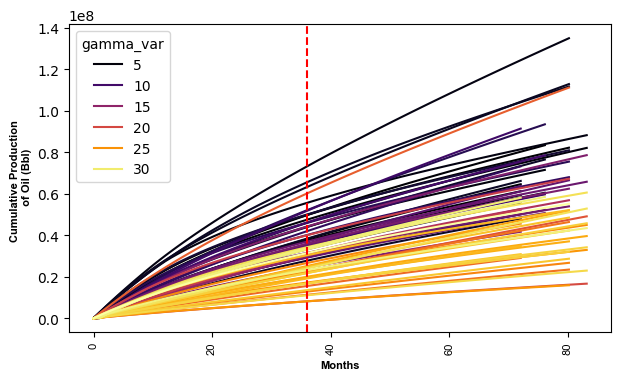

In [94]:
fig,ax = plt.subplots( figsize=(7,4 ) )

sb.lineplot( data=df, x="months",
                 y="Cumulative Oil Production, BBL",
                 hue="gamma_var",palette="inferno",ax=ax )

# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel( "Cumulative Production \n of Oil (Bbl)",fontdict={"family":"Arial","size":8,"weight":"bold"} )
ax.set_xlabel( "Months",fontdict={"family":"Arial","size":8,"weight":"bold"} )
ax.axvline(x=36,color="red",ls="--")
ax.set_xticklabels(ax.get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});

/tmp/ipykernel_41617/681984011.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});


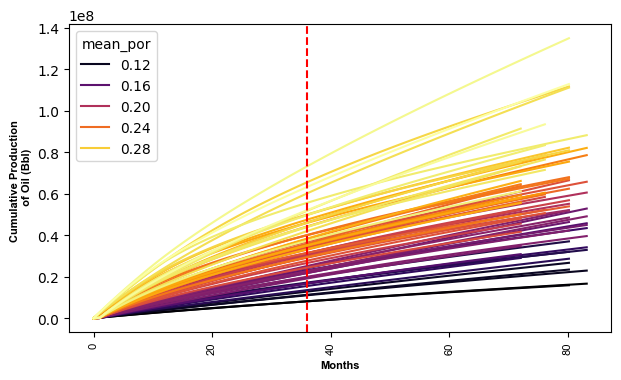

In [97]:
fig,ax = plt.subplots( figsize=(7,4 ) )

sb.lineplot( data=df, x="months",
                 y="Cumulative Oil Production, BBL",
                 hue="mean_por",palette="inferno",ax=ax )

# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel( "Cumulative Production \n of Oil (Bbl)",fontdict={"family":"Arial","size":8,"weight":"bold"} )
ax.set_xlabel( "Months",fontdict={"family":"Arial","size":8,"weight":"bold"} )
ax.axvline(x=36,color="red",ls="--")
ax.set_xticklabels(ax.get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});

/tmp/ipykernel_41617/2076334418.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});


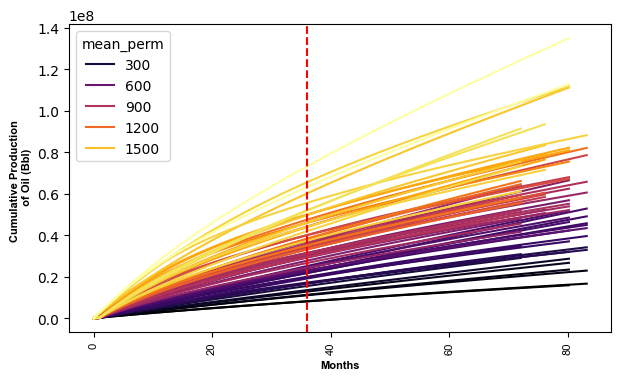

In [98]:
fig,ax = plt.subplots( figsize=(7,4 ) )

sb.lineplot( data=df, x="months",
                 y="Cumulative Oil Production, BBL",
                 hue="mean_perm",palette="inferno",ax=ax )

# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel( "Cumulative Production \n of Oil (Bbl)",fontdict={"family":"Arial","size":8,"weight":"bold"} )
ax.set_xlabel( "Months",fontdict={"family":"Arial","size":8,"weight":"bold"} )
ax.axvline(x=36,color="red",ls="--")
ax.set_xticklabels(ax.get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});

/tmp/ipykernel_41617/1183271054.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});


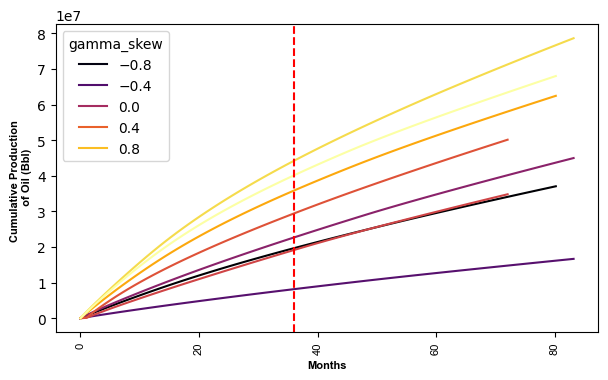

In [163]:
fig,ax = plt.subplots( figsize=(7,4 ) )

sb.lineplot( data=df, x="months",
                 y="Cumulative Oil Production, BBL",
                 hue="gamma_skew",palette="inferno",ax=ax )

# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel( "Cumulative Production \n of Oil (Bbl)",fontdict={"family":"Arial","size":8,"weight":"bold"} )
ax.set_xlabel( "Months",fontdict={"family":"Arial","size":8,"weight":"bold"} )
ax.axvline(x=36,color="red",ls="--")
ax.set_xticklabels(ax.get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});

/tmp/ipykernel_41617/1660267431.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});


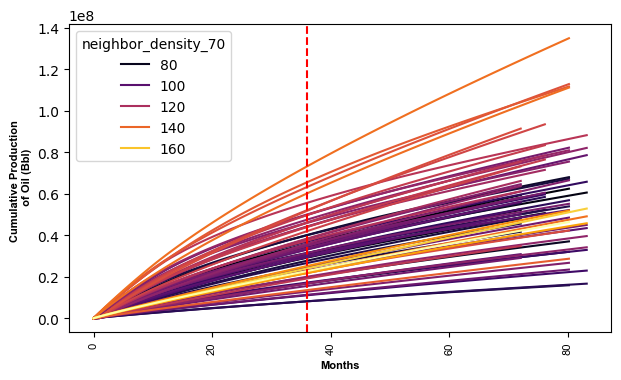

In [110]:
fig,ax = plt.subplots( figsize=(7,4 ) )

sb.lineplot( data=df, x="months",
                 y="Cumulative Oil Production, BBL",
                 hue="neighbor_density_70",palette="inferno",ax=ax )

# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel( "Cumulative Production \n of Oil (Bbl)",fontdict={"family":"Arial","size":8,"weight":"bold"} )
ax.set_xlabel( "Months",fontdict={"family":"Arial","size":8,"weight":"bold"} )
ax.axvline(x=36,color="red",ls="--")
ax.set_xticklabels(ax.get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});

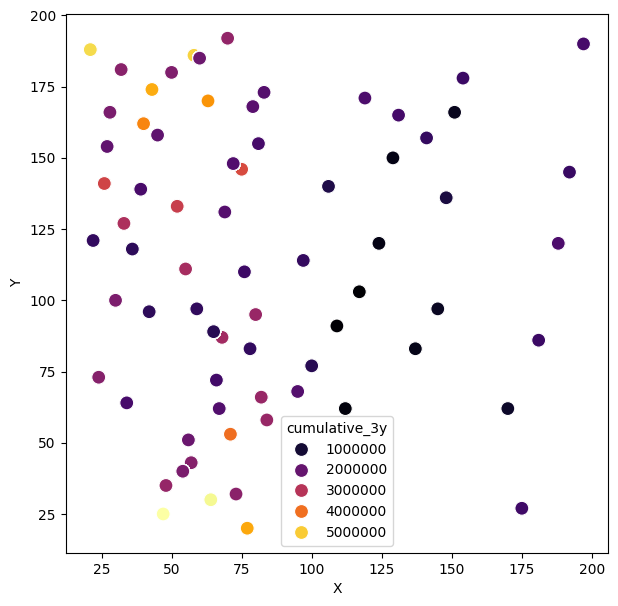

In [135]:
fig,ax = plt.subplots( figsize=(7,7) )
sb.scatterplot( data=df,x="X",y="Y",hue="cumulative_3y",palette="inferno",ax=ax,s=100 );
# ax.legend().remove()


In [171]:
df_out = df.groupby("Well_ID", as_index=False).first(  )

In [172]:
df_out = df_out[["gamma_var","mean_por","mean_perm","neighbor_density_25","neighbor_density_70","cumulative_3y"]]

/tmp/ipykernel_41617/258000566.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticklabels(  ),rotation=90);
/tmp/ipykernel_41617/258000566.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(ax[1].get_xticklabels(  ),rotation=90);
/tmp/ipykernel_41617/258000566.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2].set_xticklabels(ax[2].get_xticklabels(  ),rotation=90);


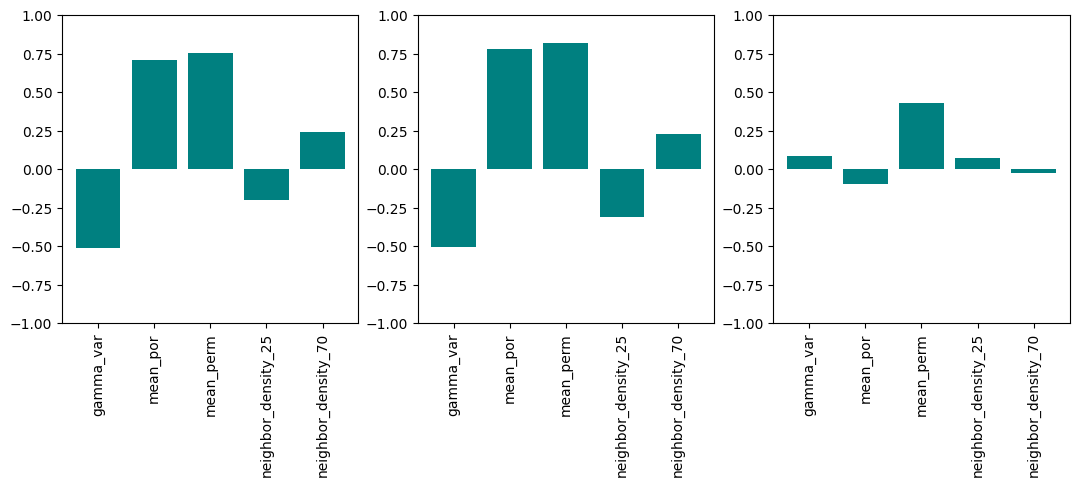

In [180]:
corrs  = [  ]
rcorrs = [  ]
pcorrs =  partial_corr(df_out.values)[:,-1][:-1]

features = [ "gamma_var","mean_por","mean_perm","neighbor_density_25","neighbor_density_70" ]
for f in features:
    corrs.append( pearsonr( df_out[f],df_out["cumulative_3y"] )[0] )
    rcorrs.append( spearmanr( df_out[f],df_out["cumulative_3y"] )[0] )
    
fig,ax = plt.subplots(1,3,figsize=(13,4))
ax[0].bar( features,corrs,color="teal" );
ax[0].set_ylim(-1,1)
ax[0].set_xticklabels(ax[0].get_xticklabels(  ),rotation=90);

ax[1].bar( features,rcorrs,color="teal" );
ax[1].set_ylim(-1,1)
ax[1].set_xticklabels(ax[1].get_xticklabels(  ),rotation=90);

ax[2].bar( features,pcorrs,color="teal" );
ax[2].set_ylim(-1,1)
ax[2].set_xticklabels(ax[2].get_xticklabels(  ),rotation=90);

In [178]:
pcorrs

[array([ 0.08736927, -0.09591195,  0.42688205,  0.07058316, -0.02292126]),
 array([ 0.08736927, -0.09591195,  0.42688205,  0.07058316, -0.02292126]),
 array([ 0.08736927, -0.09591195,  0.42688205,  0.07058316, -0.02292126]),
 array([ 0.08736927, -0.09591195,  0.42688205,  0.07058316, -0.02292126]),
 array([ 0.08736927, -0.09591195,  0.42688205,  0.07058316, -0.02292126])]